In [17]:
import pandas as pd

df = pd.read_csv('cleaned_diamond_data.csv').rename(columns = {'Unnamed: 0' : 'id'})

df.head(5)

,id,carat,clarity,color,cut,x dimension,y dimension,z dimension,depth,table,price
0,0,0.5,IF,D,IDEAL,5.1,5.15,3.20,61.5,56.0,3000.0
1,1,0.7,VVS2,E,PREMIUM,5.7,5.49,3.52,62.0,59.0,4500.0
2,2,0.5,SI2,H,GOOD,4.3,4.31,3.90,62.3,56.0,700.0
3,3,1.2,IF,D,IDEAL,5.9,6.82,4.20,61.7,58.0,10000.0
4,4,0.9,I1,J,FAIR,6.0,5.49,3.70,61.7,56.0,2400.0


In [27]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from dash import dash_table
import plotly.express as px
import pandas as pd


# Inicjalizacja aplikacji Dash
app = dash.Dash(__name__)

# Opcje dla kontrolki wyboru zmiennej
variable_options = ['carat', 'clarity', 'color', 'cut', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']

# Układ strony
app.layout = html.Div(children=[
    html.H1(children='Diamond Data Dashboard'),

    # Kontrolka wyboru zmiennej
    dcc.Dropdown(
        id='variable-dropdown',
        options=[{'label': variable, 'value': variable} for variable in variable_options],
        value='carat',
        multi=False,
        style={'width': '50%'},
        clearable=False
    ),

    # Wizualizacja rozkładu wybranej zmiennej
    dcc.Graph(id='distribution-plot'),

    # Tabela z próbką danych
    html.Div([
        html.H3('Próbka danych'),
        dash_table.DataTable(
            id='sample-data-table',
            columns=[{'name': col, 'id': col} for col in df.columns],
            data=df.sample(10).to_dict('records')
        )
    ])
])

# Funkcja do aktualizacji wykresu i tabeli na podstawie wybranej zmiennej
@app.callback(
    [Output('distribution-plot', 'figure'),
     Output('sample-data-table', 'data')],
    [Input('variable-dropdown', 'value')]
)
def update_plots(selected_variable):
    # Aktualizacja wykresu
    fig = px.histogram(df, x=selected_variable, nbins=50, title=f'Rozkład zmiennej "{selected_variable}"')

    # Aktualizacja tabeli
    sample_data = df.sample(10).to_dict('records')

    return fig, sample_data

# Uruchomienie aplikacji
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)


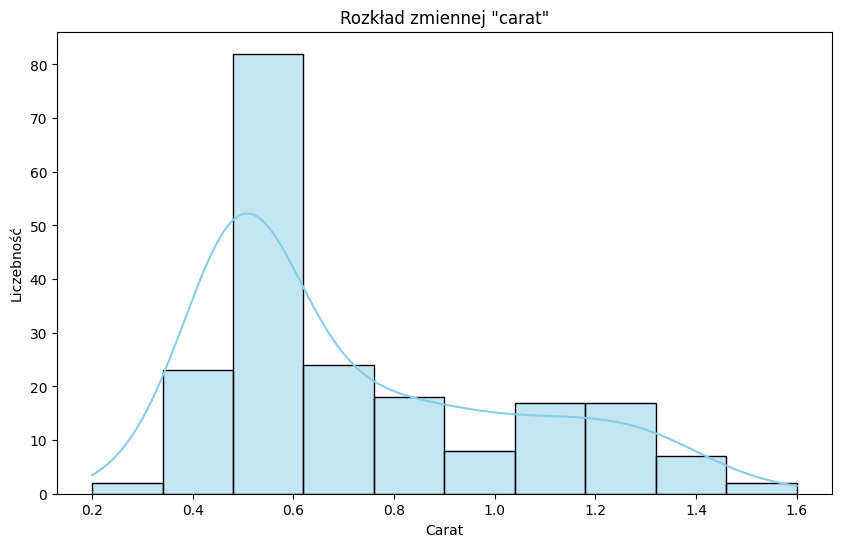

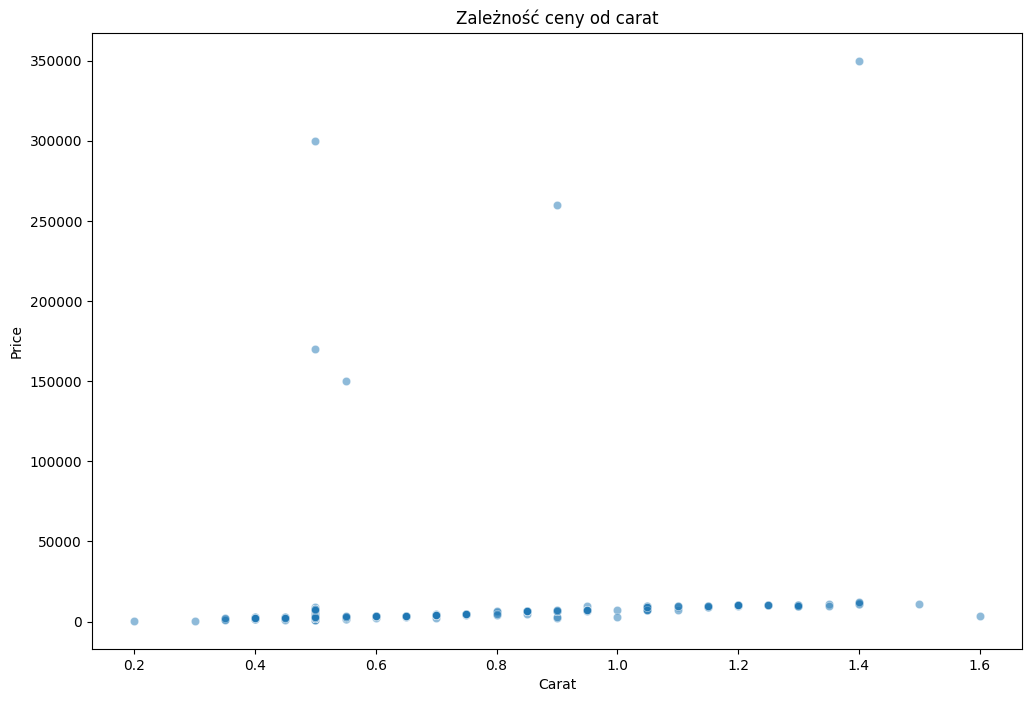

C:\Users\WIN\AppData\Local\Temp\ipykernel_45684\4205004746.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cut', data=df, palette='viridis')


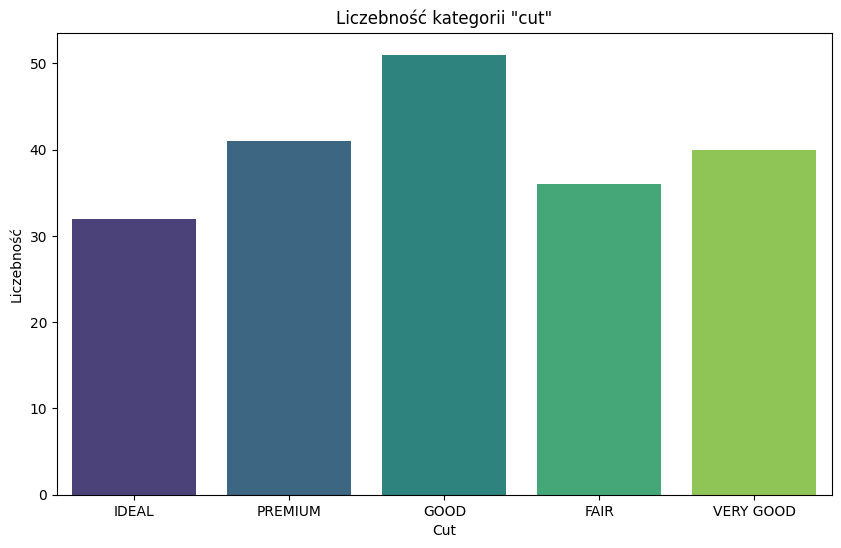

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Wizualizacja rozkładu zmiennej
plt.figure(figsize=(10, 6))
sns.histplot(df['carat'], kde=True, color='skyblue')
plt.title('Rozkład zmiennej "carat"')
plt.xlabel('Carat')
plt.ylabel('Liczebność')
plt.show()

# Wizualizacja zależności ceny od innych zmiennych
plt.figure(figsize=(12, 8))
sns.scatterplot(x='carat', y='price', data=df, alpha=0.5)
plt.title('Zależność ceny od carat')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.show()

# Wizualizacja liczebności kategorii
plt.figure(figsize=(10, 6))
sns.countplot(x='cut', data=df, palette='viridis')
plt.title('Liczebność kategorii "cut"')
plt.xlabel('Cut')
plt.ylabel('Liczebność')
plt.show()


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_table
import plotly.express as px
import pandas as pd
import statsmodels.api as sm

# Wczytaj dane

# Inicjalizacja aplikacji Dash
app = dash.Dash(__name__)

# Opcje dla kontrolki wyboru zmiennych
variable_options = ['carat', 'clarity', 'color', 'cut', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']

# Układ strony
app.layout = html.Div(children=[
    html.H1(children='Diamond Data Dashboard'),

    # Kontrolka wyboru zmiennych
    dcc.Dropdown(
        id='regression-variables',
        options=[{'label': variable, 'value': variable} for variable in variable_options],
        value=['carat'],  # Domyślne wartości
        multi=True,
        style={'width': '50%'},
        clearable=False
    ),

    # Wykres regresji
    dcc.Graph(id='regression-plot'),

    # Wyniki regresji w tabeli
    html.Div([
        html.H3('Wyniki regresji'),
        dash_table.DataTable(
            id='regression-results-table',
            columns=[{'name': 'Zmienna', 'id': 'Variable'},
                     {'name': 'Wartość współczynnika', 'id': 'Coefficient'},
                     {'name': 'P-value', 'id': 'P-value'}],
            data=[]
        )
    ])
])

# Funkcja do aktualizacji wykresu regresji i tabeli wyników
@app.callback(
    [Output('regression-plot', 'figure'),
     Output('regression-results-table', 'data')],
    [Input('regression-variables', 'value')]
)
def update_regression(selected_variables):
    # Dodaj stałą do danych
    X = sm.add_constant(df[selected_variables])

    # Dopasuj model regresji
    model = sm.OLS(df['price'], X)
    results = model.fit()

    # Wygeneruj wykres regresji
    fig = px.scatter(x=df[selected_variables[0]], y=results.fittedvalues, labels={'x': selected_variables[0], 'y': 'Predicted Price'})
    fig.update_layout(title=f'Regresja ceny od {selected_variables[0]}', xaxis_title=selected_variables[0], yaxis_title='Predicted Price')

    # Przygotuj dane do tabeli wyników
    results_data = [{'Variable': variable, 'Coefficient': results.params[variable], 'P-value': results.pvalues[variable]} for variable in results.params.index]

    return fig, results_data

# Uruchomienie aplikacji
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_table
import plotly.express as px
import pandas as pd
import statsmodels.api as sm

# Wczytaj dane

# Inicjalizacja aplikacji Dash
app = dash.Dash(__name__)

# Opcje dla kontrolki wyboru zmiennych
variable_options = ['carat', 'clarity', 'color', 'cut', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table']

# Układ strony
app.layout = html.Div(children=[
    html.H1(children='Diamond Data Dashboard'),

    # Kontrolka wyboru zmiennych
    dcc.Dropdown(
        id='regression-variables',
        options=[{'label': variable, 'value': variable} for variable in variable_options],
        value=['carat'],  # Domyślne wartości
        multi=True,
        style={'width': '50%'},
        clearable=False
    ),

    # Wykres regresji
    dcc.Graph(id='regression-plot'),

    # Wyniki regresji w tabeli
    html.Div([
        html.H3('Wyniki regresji'),
        dash_table.DataTable(
            id='regression-results-table',
            columns=[{'name': 'Zmienna', 'id': 'Variable'},
                     {'name': 'Wartość współczynnika', 'id': 'Coefficient'},
                     {'name': 'P-value', 'id': 'P-value'}],
            data=[]
        )
    ])
])

# Funkcja do aktualizacji wykresu regresji i tabeli wyników
@app.callback(
    [Output('regression-plot', 'figure'),
     Output('regression-results-table', 'data')],
    [Input('regression-variables', 'value')]
)
def update_regression(selected_variables):
    # Dodaj stałą do danych
    X = sm.add_constant(df[selected_variables])

    # Dopasuj model regresji
    model = sm.OLS(df['price'], X)
    results = model.fit()

    # Wygeneruj wykres regresji
    fig = px.scatter(x=df[selected_variables[0]], y=results.fittedvalues, labels={'x': selected_variables[0], 'y': 'Predicted Price'})
    fig.update_layout(title=f'Regresja ceny od {selected_variables[0]}', xaxis_title=selected_variables[0], yaxis_title='Predicted Price')

    # Przygotuj dane do tabeli wyników
    results_data = [{'Variable': variable, 'Coefficient': results.params[variable], 'P-value': results.pvalues[variable]} for variable in results.params.index]

    return fig, results_data

# Uruchomienie aplikacji
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)
